# Horses

Notebook detailling data exploration and model testing for Kaggle Playground Series Season 3, Episode 22-Predict Health Outcomes of Horses.

## Import

In [1]:
#import packages

import sys
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn seaborn torch catboost | grep -v 'already satisfied'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Read the dataset from a file.

train= pd.read_csv("train.csv")
test= pd.read_csv("test.csv")


pd.set_option('display.max_columns', None)




[notice] A new release of pip available: 22.2.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


Import for experimentation with PyTorch

In [2]:
import torch  # Main library
import torch.nn as nn  # For creating models
import torch.optim as optim  # For optimization algorithms
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.preprocessing import StandardScaler  # For standardizing data
from torch.utils.data import DataLoader, TensorDataset  # For creating data loaders

Check the data has been imported correctly by displaying the dataframe.

In [3]:
train.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,NaN,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


Drop columns which could potentially confuse the model.

In [4]:
# Drop irrelevant columns from the train DataFrame
train = train.drop(['id', 'cp_data', 'hospital_number'], axis=1)

# Drop the same columns from the test DataFrame (store ids for later)
test_ids = test['id'].copy()
test = test.drop(['id', 'cp_data','hospital_number'], axis=1)

## Assess The Data

The dataset will first be explored using a variety of methods to get a better idea of the distributions in the data and any potential correlations or lack thereof. 

In [5]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   rectal_temp            1235 non-null   float64
 3   pulse                  1235 non-null   float64
 4   respiratory_rate       1235 non-null   float64
 5   temp_of_extremities    1196 non-null   object 
 6   peripheral_pulse       1175 non-null   object 
 7   mucous_membrane        1214 non-null   object 
 8   capillary_refill_time  1229 non-null   object 
 9   pain                   1191 non-null   object 
 10  peristalsis            1215 non-null   object 
 11  abdominal_distention   1212 non-null   object 
 12  nasogastric_tube       1155 non-null   object 
 13  nasogastric_reflux     1214 non-null   object 
 14  nasogastric_reflux_ph  1235 non-null   float64
 15  rect

Build a function to return relvant info about the columns of the dataset.

In [6]:
def assess_data(df):
    # Getting Basic Information
    info = pd.DataFrame()
    info['Columns'] = df.columns
    info['Data Type'] = [df[col].dtype for col in df.columns]
    info['Non-null Count'] = df.count().values
    info['Unique Count'] = [df[col].nunique() for col in df.columns]
    info['Top Value'] = [df[col].mode()[0] for col in df.columns]
    info.set_index('Columns', inplace=True)

    # Getting Descriptive Statistics for numerical columns
    desc_stats = df.describe(include=[np.number]).transpose()

    # Merging Basic Information and Descriptive Statistics
    merged_info = pd.concat([info, desc_stats], axis=1, sort=False)

    return merged_info




train_assessment = assess_data(train)
test_assessment = assess_data(test)

train_assessment

,Data Type,Non-null Count,Unique Count,Top Value,count,mean,std,min,25%,50%,75%,max
surgery,object,1235,2,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,object,1235,2,adult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rectal_temp,float64,1235,43,38.0,1235.0,38.202186,0.788668,35.4,37.8,38.2,38.6,40.8
pulse,float64,1235,50,48.0,1235.0,79.574089,29.108638,30.0,53.0,76.0,100.0,184.0
respiratory_rate,float64,1235,37,24.0,1235.0,30.054251,16.452066,8.0,18.0,28.0,36.0,96.0
temp_of_extremities,object,1196,4,cool,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peripheral_pulse,object,1175,4,reduced,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mucous_membrane,object,1214,6,pale_pink,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capillary_refill_time,object,1229,3,less_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pain,object,1191,6,depressed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
test_assessment

,Data Type,Non-null Count,Unique Count,Top Value,count,mean,std,min,25%,50%,75%,max
surgery,object,824,2,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,object,824,2,adult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rectal_temp,float64,824,34,38.0,824.0,38.244539,0.785234,36.0,37.8,38.2,38.6,40.8
pulse,float64,824,49,52.0,824.0,80.229369,29.164711,36.0,54.0,76.0,100.0,184.0
respiratory_rate,float64,824,38,24.0,824.0,30.719660,17.431910,9.0,18.0,28.0,36.0,96.0
temp_of_extremities,object,789,4,cool,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peripheral_pulse,object,777,4,reduced,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mucous_membrane,object,811,6,pale_cyanotic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capillary_refill_time,object,818,3,less_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pain,object,795,6,depressed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observing the data, we can see there are a lot of categroical values and many columns with missing values. lesion_3 only has 1 unique value in the test set so should be dropped. hospital_number while a numeric value should be categoric. 

Seperate numerical and categorical features.

In [8]:
numerical_features = test._get_numeric_data().drop('lesion_3', axis = 1).columns
categorical_features = test.drop(numerical_features, axis = 1).drop('lesion_3', axis = 1).columns



In [9]:
# Get the distribution of 'outcome' in the train DataFrame
outcome_distribution = train['outcome'].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies of unique values

# Display the distribution
print("Distribution of 'outcome':")
print(outcome_distribution)

Distribution of 'outcome':
outcome
lived         46.477733
died          33.198381
euthanized    20.323887
Name: proportion, dtype: float64


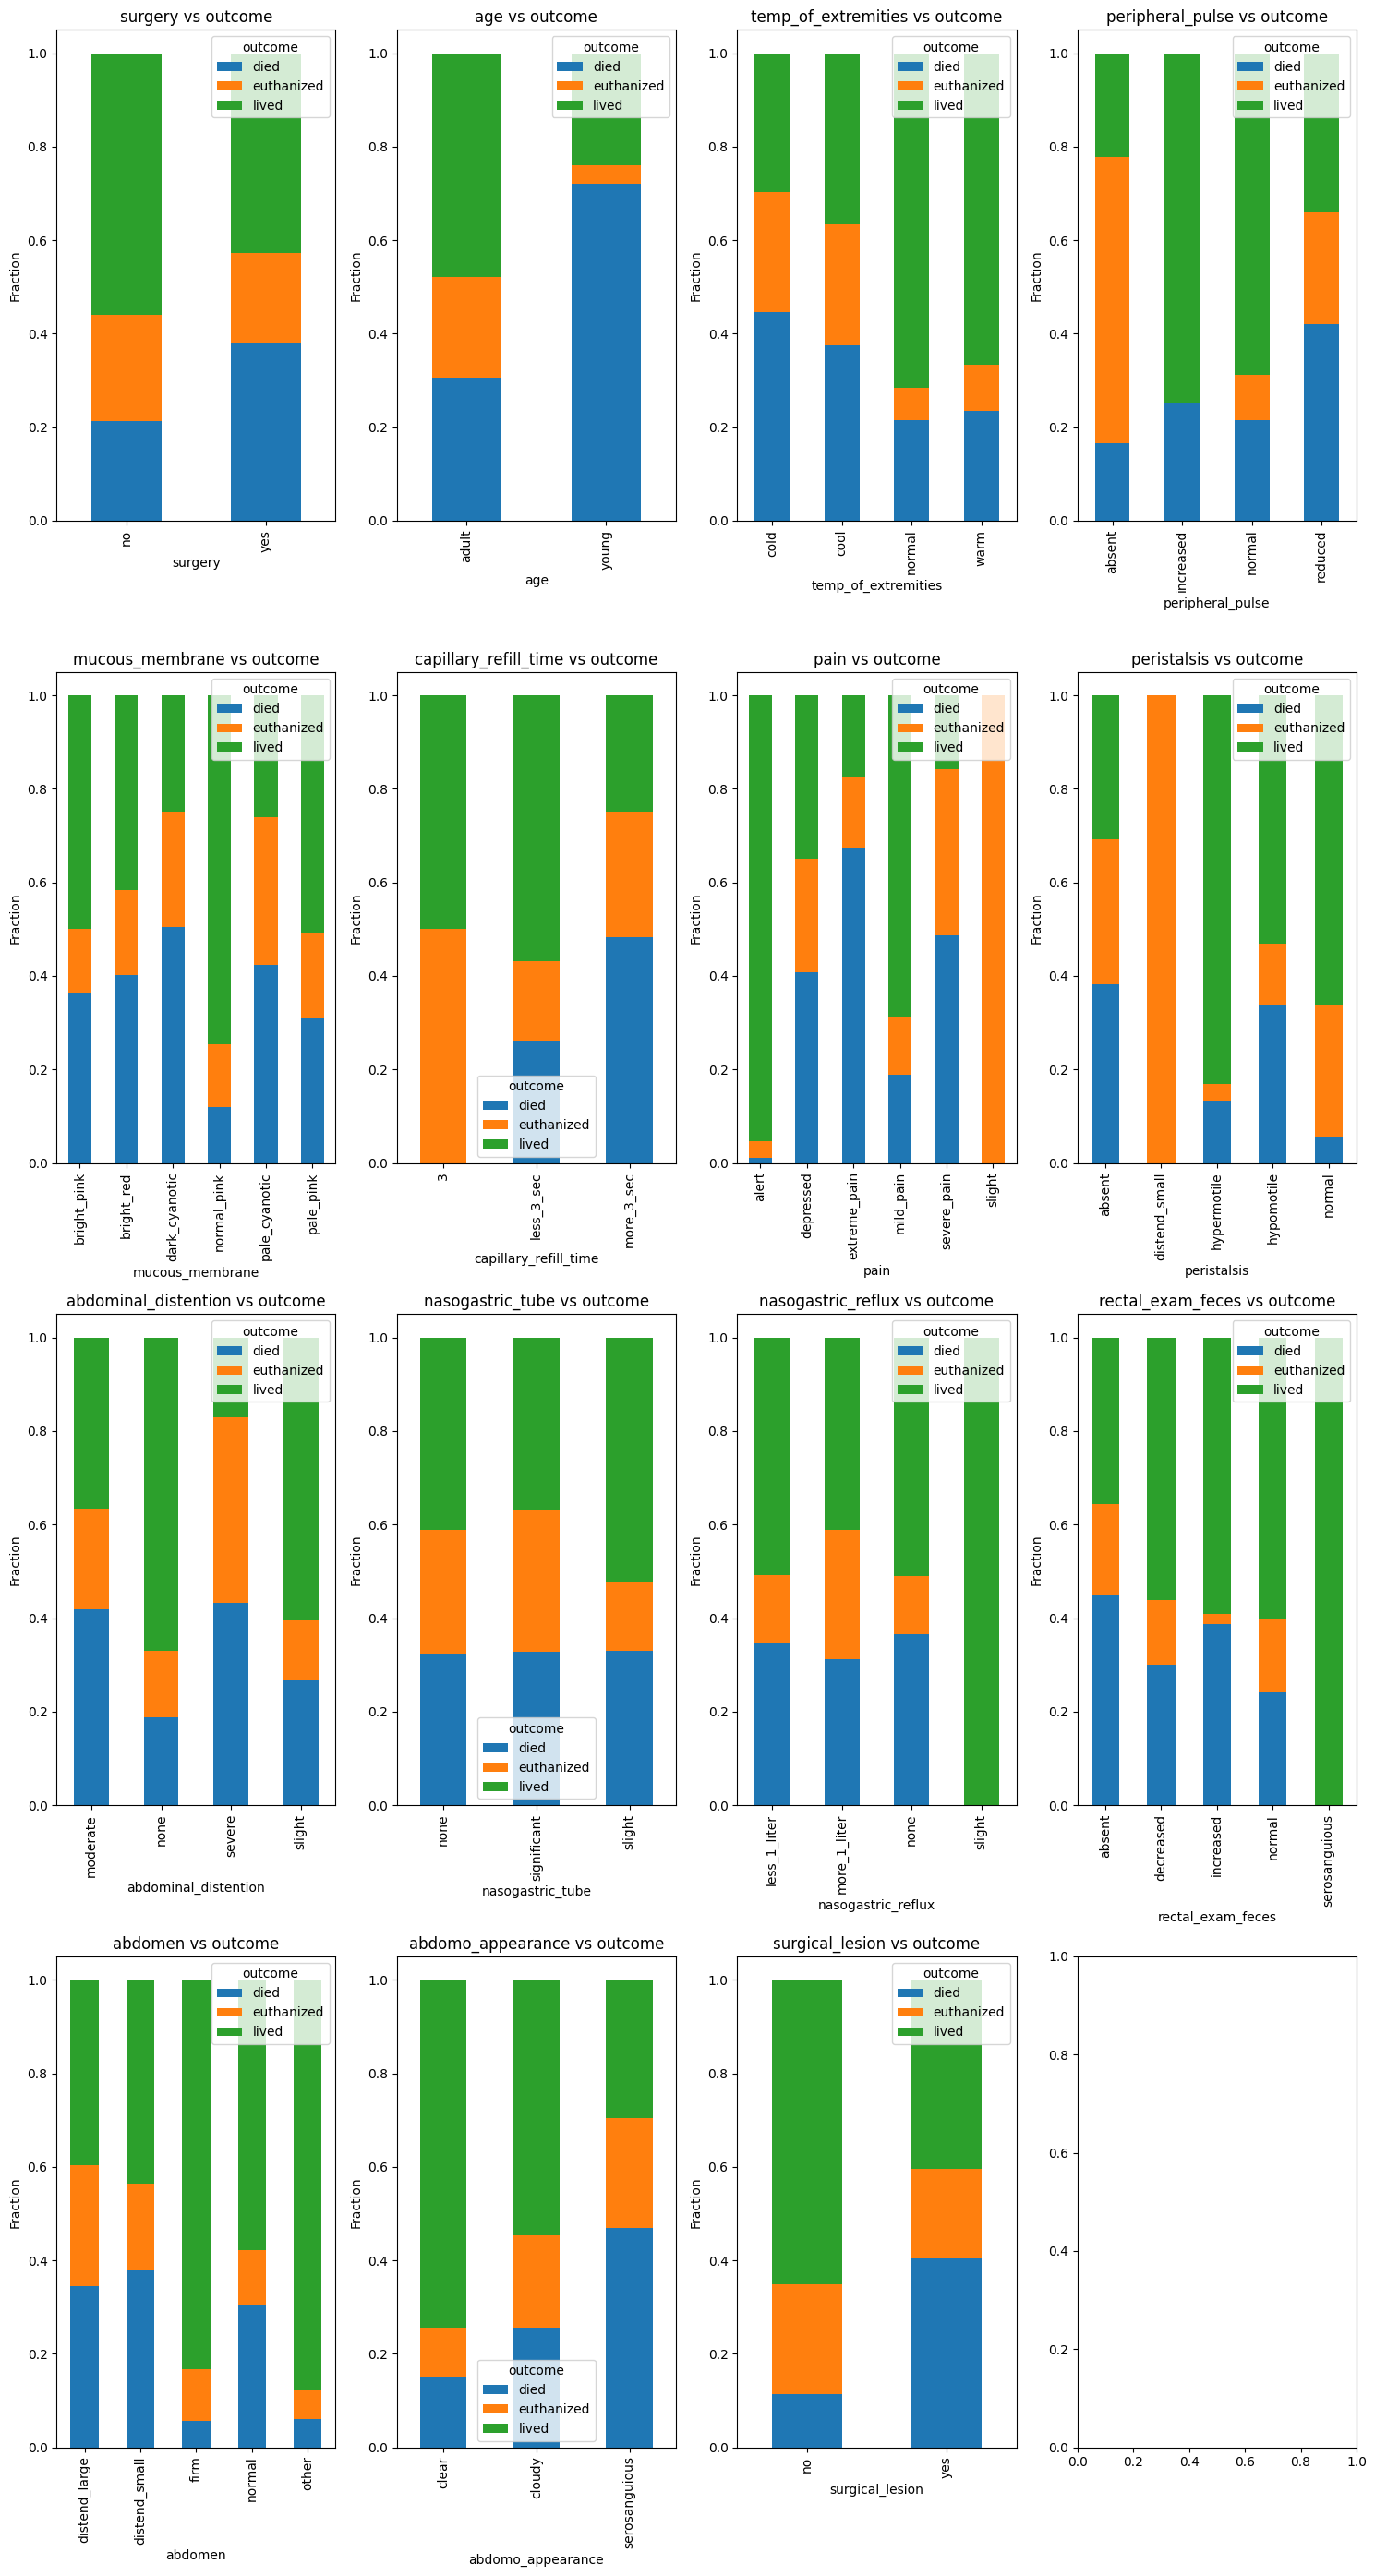

In [10]:
outcome_column = 'outcome'

# Number of Columns in the grid
ncols = 4
nrows = int(-(-len(categorical_features) // ncols))  # Calculate the number of rows required in the grid

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7 * nrows))

# If there are multiple rows and columns, axs is a 2D array.
# If there's only one row, axs is a 1D array.
# This normalizes axs to always be a 2D array.
if nrows == 1:
    axs = [axs]

# Loop over all categorical features and plot them in a subplot
for idx, feature in enumerate(categorical_features):
    row = idx // ncols
    col = idx % ncols
    cross_tab = pd.crosstab(train[feature], train[outcome_column], normalize='index')
    cross_tab.plot(kind='bar', stacked=True, ax=axs[row][col])
    axs[row][col].set_title(f'{feature} vs {outcome_column}')
    axs[row][col].set_ylabel('Fraction')
    axs[row][col].set_xlabel(feature)

plt.tight_layout()
plt.show()

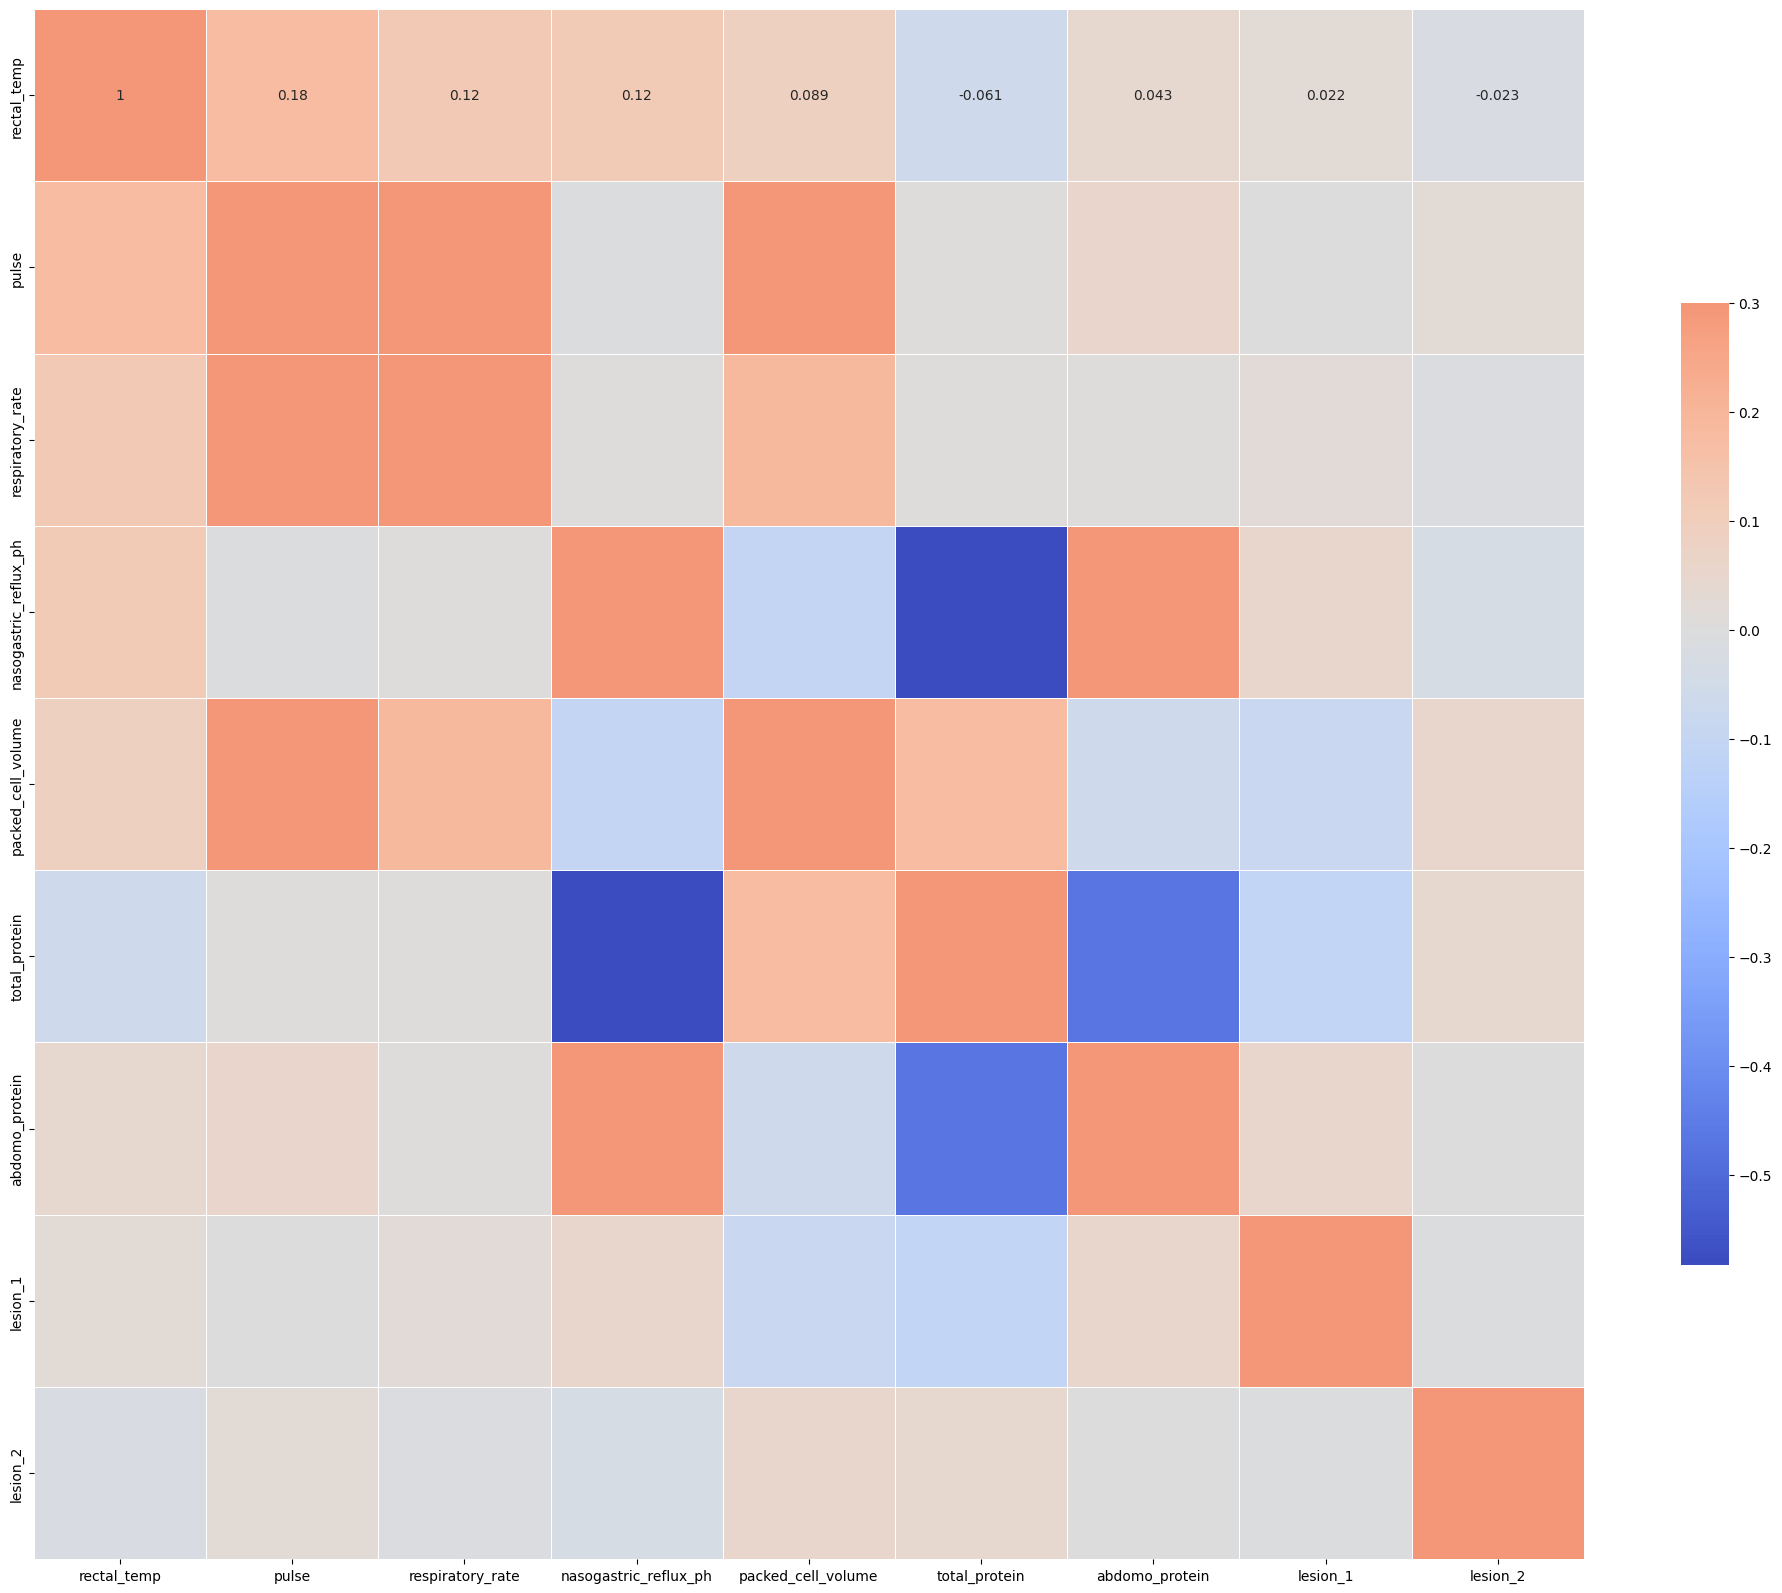

In [32]:
plt.figure(figsize=(25, 25))

# Compute the correlation matrix
corr = train[numerical_features].corr()



# Draw the heatmap with the mask and correct aspect ratio, and annotate
sns.heatmap(corr, cmap='coolwarm', vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [12]:
# Drop the 'outcome' column to create the feature DataFrame and keep 'outcome' as the target DataFrame
X_train_full = train.drop('outcome', axis=1)
y_train_full = train['outcome'].values  # Keeping it as DataFrame by passing list containing the column name

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [13]:
# Convert the tensor to a pandas Series
y_val_series = pd.Series(y_val)

# Get the distribution of 'outcome' in the y_val tensor
outcome_distribution = y_val_series.value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies of unique values

# Display the distribution
print("Distribution of 'outcome':")
print(outcome_distribution)

Distribution of 'outcome':
lived         48.987854
died          29.149798
euthanized    21.862348
Name: proportion, dtype: float64


Naive model predicting only lived would have an accuracy of 49%.

In [14]:
#Build a pipeline using Column Transformer to simulataneously impute median values for NaNs in numerical data, scale it
#and also encode the categorical data. The output is a sparse matrix, which we convert to an array.


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#define pipeline for transforming numerical data
numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler()),
    ])

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer



#Use column tranformer to simultaneously apply tranformation to both types of attributes
full_pipeline = ColumnTransformer([
    ("numerical", numerical_pipeline, numerical_features),
    ("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_features),
])

#apply to data
#output will be a sparse matrix so convert to an array
X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared = full_pipeline.transform(X_val)
X_test_prepared = full_pipeline.transform(test)
X_train_full_prepared = full_pipeline.transform(X_train_full)




In [15]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.squeeze())  # squeeze() is used to convert DataFrame to Series
y_val_encoded = label_encoder.transform(y_val.squeeze())
# Display mapping of original class labels to integers
for original_class, encoded_label in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{encoded_label} -> {original_class}")
# Convert prepared data to PyTorch tensors
X_train_prepared = torch.FloatTensor(X_train_prepared)  # if X_train_prepared is sparse matrix
X_val_prepared = torch.FloatTensor(X_val_prepared)  # if X_val_prepared is sparse matrix
y_train = torch.LongTensor(y_train_encoded)
y_val = torch.LongTensor(y_val_encoded)
X_test_prepared = torch.FloatTensor(X_test_prepared)  # if X_test_prepared is sparse matrix
X_train_full_prepared = torch.FloatTensor(X_train_full_prepared)  # if X_train_full_prepared is sparse matrix
y_train_full = torch.LongTensor(label_encoder.transform(y_train_full.squeeze()))  # squeeze() is used to convert DataFrame to Series

0 -> died
1 -> euthanized
2 -> lived


# Build our model

In [18]:
import torch.nn as nn
import torch.optim as optim

class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=3):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

nn.Module: It is the base class for all neural network modules in PyTorch.
<br>
init(): This method initializes the layers of the neural network.
<br>
nn.Linear(in_features, out_features): Applies a linear transformation to the incoming data. in_features is the size of each input sample, and out_features is the size of each output sample.
<br>
nn.ReLU(): Applies the ReLU activation function element-wise. It's used to introduce non-linearity to the model, allowing it to learn complex patterns.
<br>
forward(x): Defines the forward pass of the network. It takes the input x and passes it through each layer and returns the output

In [19]:
class ImprovedSimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=3, dropout_rate=0.5):
        super(ImprovedSimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  # Batch Normalization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)  # Dropout
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)  # Batch Normalization
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

input_size = X_train_prepared.shape[1]  # Number of features in your dataset
hidden_size = 256  # You can vary this
# Initialize the model
model = ImprovedSimpleNet(input_size, hidden_size)

# Use weight decay as a form of regularization
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
# Employ learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

In [20]:

model = SimpleNet(input_size, hidden_size)


optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [21]:
epochs = 10000
for epoch in range(epochs):
    # Convert the pandas DataFrame to PyTorch tensor
    inputs = torch.FloatTensor(X_train_prepared)
    labels = torch.LongTensor(y_train_encoded)

    # Forward pass: Compute predicted y by passing x to the model
    outputs = model(inputs)

    # Compute the loss
    loss = criterion(outputs, labels)

    # Zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [100/10000], Loss: 0.6076
Epoch [200/10000], Loss: 0.4448
Epoch [300/10000], Loss: 0.2948
Epoch [400/10000], Loss: 0.1765
Epoch [500/10000], Loss: 0.1038
Epoch [600/10000], Loss: 0.0635
Epoch [700/10000], Loss: 0.0414
Epoch [800/10000], Loss: 0.0285
Epoch [900/10000], Loss: 0.0205
Epoch [1000/10000], Loss: 0.0154
Epoch [1100/10000], Loss: 0.0119
Epoch [1200/10000], Loss: 0.0094
Epoch [1300/10000], Loss: 0.0077
Epoch [1400/10000], Loss: 0.0063
Epoch [1500/10000], Loss: 0.0053
Epoch [1600/10000], Loss: 0.0045
Epoch [1700/10000], Loss: 0.0038
Epoch [1800/10000], Loss: 0.0033
Epoch [1900/10000], Loss: 0.0029
Epoch [2000/10000], Loss: 0.0025
Epoch [2100/10000], Loss: 0.0022
Epoch [2200/10000], Loss: 0.0020
Epoch [2300/10000], Loss: 0.0018
Epoch [2400/10000], Loss: 0.0016
Epoch [2500/10000], Loss: 0.0014
Epoch [2600/10000], Loss: 0.0013
Epoch [2700/10000], Loss: 0.0012
Epoch [2800/10000], Loss: 0.0010
Epoch [2900/10000], Loss: 0.0010
Epoch [3000/10000], Loss: 0.0009
Epoch [3100/10000],

In [22]:
# Switch to evaluation mode
model.eval()

with torch.no_grad():
    inputs = torch.FloatTensor(X_val_prepared)
    labels = torch.LongTensor(y_val_encoded)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    print(f'Accuracy of the model on the {total} validation samples: {100 * correct / total}%')

Accuracy of the model on the 247 validation samples: 63.96761133603239%


Plot a confusion matrix of models predictions.

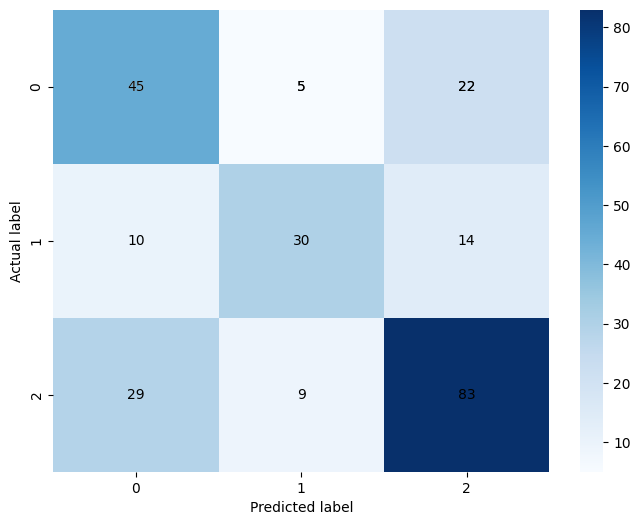

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val.numpy(), predicted.numpy()).astype(int)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Manually set annotations if they are not showing
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j+0.5, i+0.5, cm[i, j], 
                 horizontalalignment='center', 
                 verticalalignment='center')

plt.show()


Run model on test data

In [24]:


# Set the model to evaluation mode and run it on the test data
model.eval()
with torch.no_grad():
    outputs = model(X_test_prepared)
    _, predicted = torch.max(outputs, 1)  # get the predicted classes

# Convert the integer predictions back to original class labels
predicted_labels = label_encoder.inverse_transform(predicted.numpy())

# Create a DataFrame with the id column and the corresponding predictions
output_df = pd.DataFrame({'id': test_ids, 'outcome': predicted_labels})

output_df.to_csv('horse_predictions2.csv', index=False)

# Gradient Boosting Model

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Define the model
gb_model = GradientBoostingClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

# Fit the model
grid_search.fit(X_train_prepared, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Validate the model with best parameters
best_gb_model = grid_search.best_estimator_
y_val_pred = best_gb_model.predict(X_val_prepared)

# Calculate Accuracy on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Best Model Accuracy on Validation Set: {accuracy * 100:.2f}%')


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.3s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.3s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.3s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.3s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ...learning_rate=0.01, max_depth=4, n_estimators=50; total time=   0.3s
[CV] END ...learning_rate=0.01, max_depth=4, n_

In [26]:
# Predict on the test set
y_test_pred = best_gb_model.predict(X_test_prepared)

# Convert numerical predictions to original labels
y_test_pred_labels = label_encoder.inverse_transform(y_test_pred)

# Create the output DataFrame and write to CSV
output_df_gb = pd.DataFrame({'id': test_ids, 'outcome': y_test_pred_labels})
output_df_gb.to_csv('gradient_boosting_predictions_tuned.csv', index=False)

# Catboost Model

In [27]:
from catboost import CatBoostClassifier

In [28]:
# Define the model
cat_model = CatBoostClassifier(random_state=42, verbose=0)
X_train_prepared = pd.DataFrame(X_train_prepared) if not isinstance(X_train_prepared, (pd.DataFrame, np.ndarray)) else X_train_prepared
X_val_prepared = pd.DataFrame(X_val_prepared) if not isinstance(X_val_prepared, (pd.DataFrame, np.ndarray)) else X_val_prepared
X_test_prepared = pd.DataFrame(X_test_prepared) if not isinstance(X_test_prepared, (pd.DataFrame, np.ndarray)) else X_test_prepared
y_train = y_train if isinstance(y_train, (pd.Series, np.ndarray)) else pd.Series(y_train)
# Define the parameter grid
param_grid = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
}

# Initialize GridSearchCV
grid_search_cat = GridSearchCV(estimator=cat_model, param_grid=param_grid, 
                               cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

# Fit the model
grid_search_cat.fit(X_train_prepared, y_train)

# Get the best parameters
best_params_cat = grid_search_cat.best_params_
print(f'Best Parameters: {best_params_cat}')

# Validate the model with best parameters
best_cat_model = grid_search_cat.best_estimator_
y_val_pred_cat = best_cat_model.predict(X_val_prepared)

# Calculate Accuracy on the validation set
accuracy_cat = accuracy_score(y_val, y_val_pred_cat)
print(f'Best Model Accuracy on Validation Set: {accuracy_cat * 100:.2f}%')


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .........depth=4, iterations=50, learning_rate=0.01; total time=   0.2s
[CV] END .........depth=4, iterations=50, learning_rate=0.01; total time=   0.2s
[CV] END ..........depth=4, iterations=50, learning_rate=0.1; total time=   0.2s
[CV] END ..........depth=4, iterations=50, learning_rate=0.1; total time=   0.2s
[CV] END ..........depth=4, iterations=50, learning_rate=0.1; total time=   0.2s
[CV] END .........depth=4, iterations=50, learning_rate=0.01; total time=   0.2s
[CV] END .........depth=4, iterations=50, learning_rate=0.01; total time=   0.2s
[CV] END .........depth=4, iterations=50, learning_rate=0.01; total time=   0.2s
[CV] END ..........depth=4, iterations=50, learning_rate=0.1; total time=   0.0s
[CV] END ..........depth=4, iterations=50, learning_rate=0.1; total time=   0.1s
[CV] END ..........depth=4, iterations=50, learning_rate=0.2; total time=   0.1s
[CV] END ..........depth=4, iterations=50, lear

Cat boost has best accuracy of models tested.

Fit cat boost on full training set

In [29]:
X_train_full_prepared= pd.DataFrame(X_train_full_prepared) if not isinstance(X_train_full_prepared, (pd.DataFrame, np.ndarray)) else X_train_full_prepared
y_train_full = y_train_full if isinstance(y_train_full, (pd.Series, np.ndarray)) else pd.Series(y_train_full)
# Define the parameter grid
param_grid = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
}

# Initialize GridSearchCV
grid_search_cat = GridSearchCV(estimator=cat_model, param_grid=param_grid, 
                               cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

# Fit the model
grid_search_cat.fit(X_train_prepared, y_train)

# Get the best parameters
best_params_cat = grid_search_cat.best_params_
print(f'Best Parameters: {best_params_cat}')

# Validate the model with best parameters
best_cat_model = grid_search_cat.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .........depth=4, iterations=50, learning_rate=0.01; total time=   0.1s
[CV] END .........depth=4, iterations=50, learning_rate=0.01; total time=   0.1s
[CV] END .........depth=4, iterations=50, learning_rate=0.01; total time=   0.1s
[CV] END .........depth=4, iterations=50, learning_rate=0.01; total time=   0.1s
[CV] END .........depth=4, iterations=50, learning_rate=0.01; total time=   0.1s
[CV] END ..........depth=4, iterations=50, learning_rate=0.1; total time=   0.1s
[CV] END ..........depth=4, iterations=50, learning_rate=0.1; total time=   0.1s
[CV] END ..........depth=4, iterations=50, learning_rate=0.1; total time=   0.1s
[CV] END ..........depth=4, iterations=50, learning_rate=0.1; total time=   0.1s
[CV] END ..........depth=4, iterations=50, learning_rate=0.2; total time=   0.1s
[CV] END ..........depth=4, iterations=50, learning_rate=0.2; total time=   0.1s
[CV] END ..........depth=4, iterations=50, lear

In [30]:
# Predict on the test set
y_test_pred_cat = best_cat_model.predict(X_test_prepared)

# Convert numerical predictions to original labels
y_test_pred_labels_cat = label_encoder.inverse_transform(y_test_pred_cat)

# Create the output DataFrame and write to CSV
output_df_cat = pd.DataFrame({'id': test_ids, 'outcome': y_test_pred_labels_cat})
output_df_cat.to_csv('catboost_predictions_tuned2.csv', index=False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
